In [410]:
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn.metrics import accuracy_score, roc_auc_score
import statistics as st

In [2]:
with open('tickers.txt','r') as file:
    tickers = file.readlines()
    
tickers = [item.strip() for item in tickers]

In [3]:
columns = ['transaction_date', 'transaction_type', 'company_name',
           'ticker', 'name', 'position', 'shares_traded', 'avg_price',
           'total_price', 'shares_owned', 'own_type']



In [4]:
def file_readr(ticker_list):
    my_dict = {}
    for ticker in ticker_list:
        try:
            current_df = pd.read_csv(f'./insiders_{ticker}.csv', header = None, names = columns)
            if current_df.shape[0] > 0:
                my_dict[ticker] = current_df
            else:
                continue
            del current_df
        except:
            continue
    
    return my_dict



In [202]:
dict_insiders = file_readr(tickers)




### cleaning insiders dictionary 

In [201]:

def clean_dict(x_dict):
    local_dict = {}
    
    for ticker in x_dict.keys():
        df = x_dict[ticker]
        
        if df.shape[0] < 25:
            continue
            
        else:
            
            df.set_index(pd.to_datetime(df.transaction_date), inplace = True)

            df.drop('transaction_date',axis=1, inplace = True)

            transactions_list = [item.split('(')[0] for item in df.transaction_type.tolist()]

            df['sale_num'] = [1 if item == 'Sale' else 0 for item in transactions_list]
            df['buy_num'] = [1 if item == 'Purchase' else 0 for item in transactions_list]

            weekly = df.set_index(df.index-timedelta(days=7)).resample('W-SUN').sum()[['shares_traded','total_price','sale_num','buy_num']]

            weekly.index.name = 'Date'

            local_dict[ticker] = weekly

            print(f'{ticker} cleaned successfully')

    return local_dict
    

In [203]:
dict_insiders = clean_dict(dict_insiders)

FCX cleaned successfully
MAS cleaned successfully
HAS cleaned successfully
AMZN cleaned successfully
MU cleaned successfully
VAR cleaned successfully
PEG cleaned successfully
LEG cleaned successfully
JBHT cleaned successfully
CAT cleaned successfully
K cleaned successfully
HES cleaned successfully
NDAQ cleaned successfully
BLL cleaned successfully
AAP cleaned successfully
VTR cleaned successfully
PG cleaned successfully
NSC cleaned successfully
PBCT cleaned successfully
AMAT cleaned successfully
MAR cleaned successfully
INCY cleaned successfully
ORLY cleaned successfully
ROL cleaned successfully
JWN cleaned successfully
NEE cleaned successfully
QRVO cleaned successfully
CVX cleaned successfully
HUM cleaned successfully
NBL cleaned successfully
BDX cleaned successfully
AWK cleaned successfully
SJM cleaned successfully
PXD cleaned successfully
CHD cleaned successfully
AMP cleaned successfully
DRI cleaned successfully
AEE cleaned successfully
ABMD cleaned successfully
CTXS cleaned success

### cleaning stock price data

In [205]:
def get_stocks(x_dict):
    stocks_dict = {}
    
    for ticker in x_dict.keys():
        start_date = str(x_dict[ticker].index[0]).split()[0]
        end_date = str(x_dict[ticker].index[-1]).split()[0]
        
        try:
            stocks_df = data.DataReader(ticker,'yahoo',start_date,end_date)
        except:
            continue
        
        stocks_dict[ticker]=stocks_df
        
    return stocks_dict
        
        

In [206]:
def clean_stocks(x_dict):    
    stocks_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        stocks_df = x_dict[ticker]
        stocks_df['return_std'] = stocks_df['Adj Close'].diff()
        
        stocks_weekly = stocks_df.set_index(stocks_df.index-timedelta(days=7)).resample('W-SUN').std()[['return_std']]
        
        stocks_dict[ticker]=stocks_weekly
        
    return stocks_dict

In [207]:
stocks_dict_pre = get_stocks(dict_insiders)

In [208]:
stocks_dict = clean_stocks(stocks_dict_pre)

#### merging and cleaning insider & stock data

In [210]:
def merge_dicts(x,y):
    full_dict = {}
    x_dict = x
    y_dict = y
    
    
    for ticker in x_dict.keys():
        
        if ticker not in y_dict.keys():
            continue
            
        else:
            
            index = [item for item in list(zip(x_dict[ticker].index,y_dict[ticker].index))]
            index_test = all([item[0] == item[1] for item in index])
            
            if index_test:
                index = [item[0] for item in index]
                
                try:
                    
                    left = x_dict[ticker].loc[index]
                    right = y_dict[ticker].loc[index]

                    full_df = pd.merge(left,right, on=left.index)

                    full_df = full_df.set_index('key_0')

                    full_df.index.name = 'Date'

                    full_df.sale_num[full_df.sale_num > 0] = 1

                    full_df.buy_num[full_df.buy_num>0] = 1

                    full_df['risk_dummy'] = np.where(full_df.return_std > 1.5, 1, 0)

                    full_df = full_df.dropna()
                    
                    full_dict[ticker] = full_df

                except:
                    print(f'error on ticker:{ticker}')
            
    return full_dict
        
        
        

In [211]:
full_dict = merge_dicts(dict_insiders,stocks_dict)


/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### plotting insider trades

In [162]:

def plot_dict(insider_dict,stocks_dict):
    plt.style.use('bmh')
    fig = plt.figure(figsize=(20,15))
    
    for item in insider_dict.keys():
        
        ticker = item
        
        if ticker not in stocks_dict.keys():
            
            continue
            
        else:
            
            stock_df = stocks_dict[ticker]
            insider_df = insider_dict[ticker]
            
            sns.lineplot(x=stock_df.index,y=stock_df['Adj Close'])
            for x in insider_df.index.tolist():
                plt.axvline(x,linestyle=':',linewidth=0.1,c='b')
                    
        

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


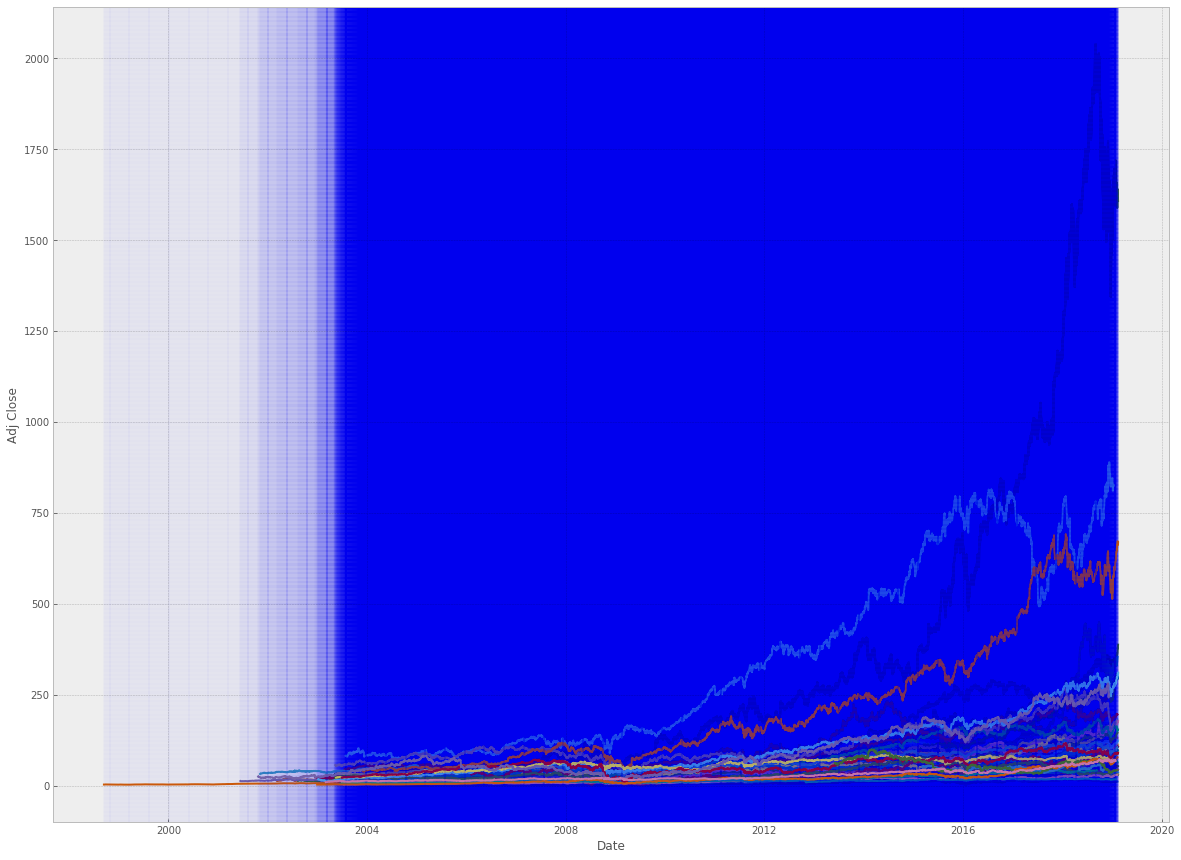

In [163]:
plot_dict(dict_insiders,stocks_dict_pre)

### fitting model

In [458]:
full_dict['FCX']['risk_dummy'].unique()[1]

dict_values([{0: 796, 1: 26}, {0: 779, 1: 2}, {0: 754, 1: 33}, {1: 588, 0: 236}, {0: 765, 1: 18}, {0: 747, 1: 75}, {0: 811, 1: 3}, {0: 818, 1: 5}, {0: 760, 1: 54}, {0: 672, 1: 125}, {0: 830, 1: 11}, {0: 623, 1: 158}, {0: 786, 1: 35}, {0: 806, 1: 1}, {0: 691, 1: 179}, {0: 795, 1: 26}, {0: 807, 1: 14}, {0: 649, 1: 124}, {0: 667}, {0: 768, 1: 3}, {0: 755, 1: 49}, {0: 621, 1: 181}, {0: 620, 1: 242}, {0: 707}, {0: 530, 1: 24}, {0: 752, 1: 67}, {0: 127, 1: 87}, {0: 708, 1: 99}, {0: 566, 1: 252}, {0: 780, 1: 30}, {0: 701, 1: 131}, {0: 542, 1: 10}, {0: 742, 1: 68}, {0: 408, 1: 406}, {0: 810, 1: 4}, {0: 531, 1: 127}, {0: 785, 1: 29}, {0: 806, 1: 3}, {0: 653, 1: 150}, {0: 740, 1: 78}, {0: 813, 1: 29}, {0: 920, 1: 1}, {0: 689, 1: 130}, {0: 1063, 1: 1}, {0: 777, 1: 31}, {0: 453, 1: 36}, {0: 779}, {0: 781, 1: 30}, {0: 717, 1: 27}, {0: 813}, {0: 687, 1: 125}, {0: 706, 1: 41}, {0: 784, 1: 36}, {0: 814, 1: 4}, {0: 683, 1: 99}, {1: 576, 0: 231}, {0: 659, 1: 140}, {0: 712, 1: 97}, {0: 751, 1: 65}, {0: 8

In [459]:
def create_class_balance_df(x_dictionary, binary_label_col, columns):
    ticker_dict = {}

    for ticker in x_dictionary.keys():
        key_val_dict = {}
        for key,value in x_dictionary[ticker][label_col].value_counts().items():
            key_val_dict[key] = value
        ticker_dict[ticker] = key_val_dict
        
    
    
    ticker_list = list(ticker_dict.keys())
    zeros_label = x_dictionary[ticker][label_col].unique()[0]
    ones_label = x_dictionary[ticker][label_col].unique()[1]
    zeros_list = [item.get(zeros_label) for item in ticker_dict.values()]
    ones_list = [item.get(ones_label) for item in ticker_dict.values()]
    
    class_balance_df = pd.DataFrame(list(zip(ticker_list,zeros_list,ones_list)), columns = columns)
    
    return class_balance_df
    

In [462]:
label_col = 'risk_dummy'
columns = ['Ticker','Low_Risk','High_Risk']

class_balance_df = create_class_balance_df(full_dict, label_col, columns)

class_balance_df = class_balance_df.set_index('Ticker')
class_balance_df['Sample_Size'] = np.where(pd.isna(class_balance_df.Low_Risk + class_balance_df.High_Risk) != True,class_balance_df.Low_Risk + class_balance_df.High_Risk, class_balance_df.Low_Risk) 

class_balance_df


,Low_Risk,High_Risk,Sample_Size
Ticker,,,
FCX,796,26.0,822.0
MAS,779,2.0,781.0
HAS,754,33.0,787.0
AMZN,236,588.0,824.0
MU,765,18.0,783.0
VAR,747,75.0,822.0
PEG,811,3.0,814.0
LEG,818,5.0,823.0
JBHT,760,54.0,814.0


In [463]:
def model_dict(x_dict, shuffle = True):
    fit_dict = {}
    
    for ticker in x_dict.keys():
        
        print(ticker)
        df = x_dict[ticker]
        
        
        
        X = df[['sale_num','buy_num']]
        Y = df.risk_dummy
        x_train, x_test, y_train, y_test = ms.train_test_split(X, Y, test_size = 0.2, shuffle = shuffle)
        
        rf = ensemble.RandomForestClassifier(oob_score = True, n_jobs = -1, n_estimators = 100)
        
        result = rf.fit(x_train,y_train)
        prediction = rf.predict(x_test)
        
        fit_dict[ticker]= result,prediction,y_test
        
        
    return fit_dict

In [363]:
models_dict = model_dict(full_dict)

FCX
MAS
HAS
AMZN
MU
VAR
PEG
LEG
JBHT
CAT
K
HES
NDAQ
BLL
AAP
VTR
PG
NSC
PBCT
AMAT
MAR
INCY
ORLY
ROL
JWN
NEE
QRVO
CVX
HUM
NBL
BDX
AWK
SJM
PXD
CHD
AMP
DRI
AEE
ABMD
CTXS
HSY
MDLZ
UNH
UDR
CCI
VRSK
AEP
JNJ
LOW
CMCSA
MMM
PPG
ADP
AJG
EW
AZO
SNA
ALB
CHRW
UPS
FDX
DISH
MTD
FAST
ROP
LNT
XOM
WU
PRU
COO
CPRI
CSX
ABT


In [396]:
idx_list = []
oob_list = []
feature_importance_list = []

for idx, ticker in enumerate(models_dict.keys()):
    idx_list.append(idx)
    oob_list.append(models_dict[ticker][0].oob_score_)
    feature_importance_list.append(models_dict[ticker][0].feature_importances_)



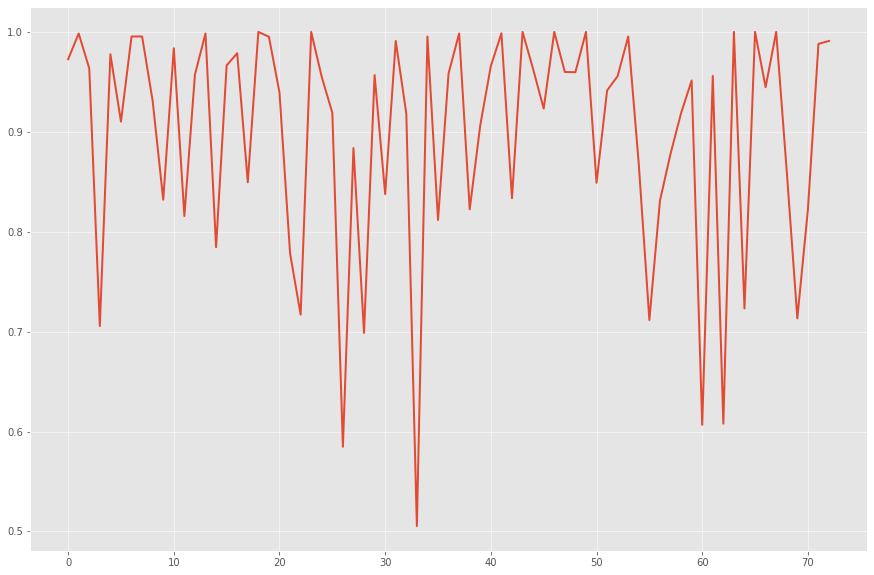

In [404]:
plt.figure(figsize=(15,10))
plt.plot(idx_list,oob_list)


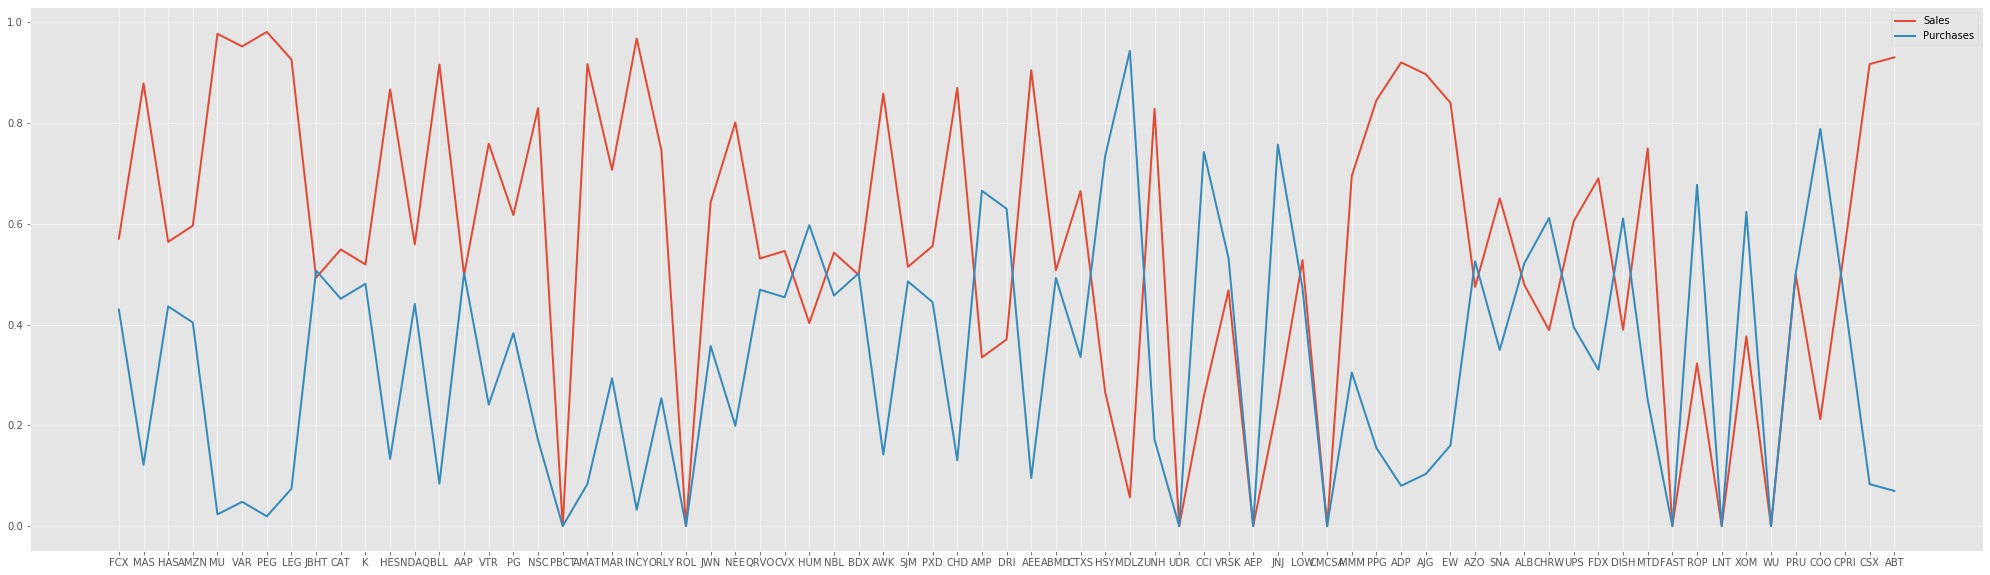

In [443]:
plt.figure(figsize=(35,10))
plt.plot(list(models_dict.keys()), feature_importance_list)
plt.legend(['Sales','Purchases'])

In [444]:
full_dict['FCX'].columns

Index(['shares_traded', 'total_price', 'sale_num', 'buy_num', 'return_std',
       'risk_dummy'],
      dtype='object')

In [445]:
total_buys_list = []
total_sales_list = []
for ticker in full_dict.keys():
    total_buys_list.append(full_dict[ticker].buy_num.sum())
    total_sales_list.append(full_dict[ticker].sale_num.sum())






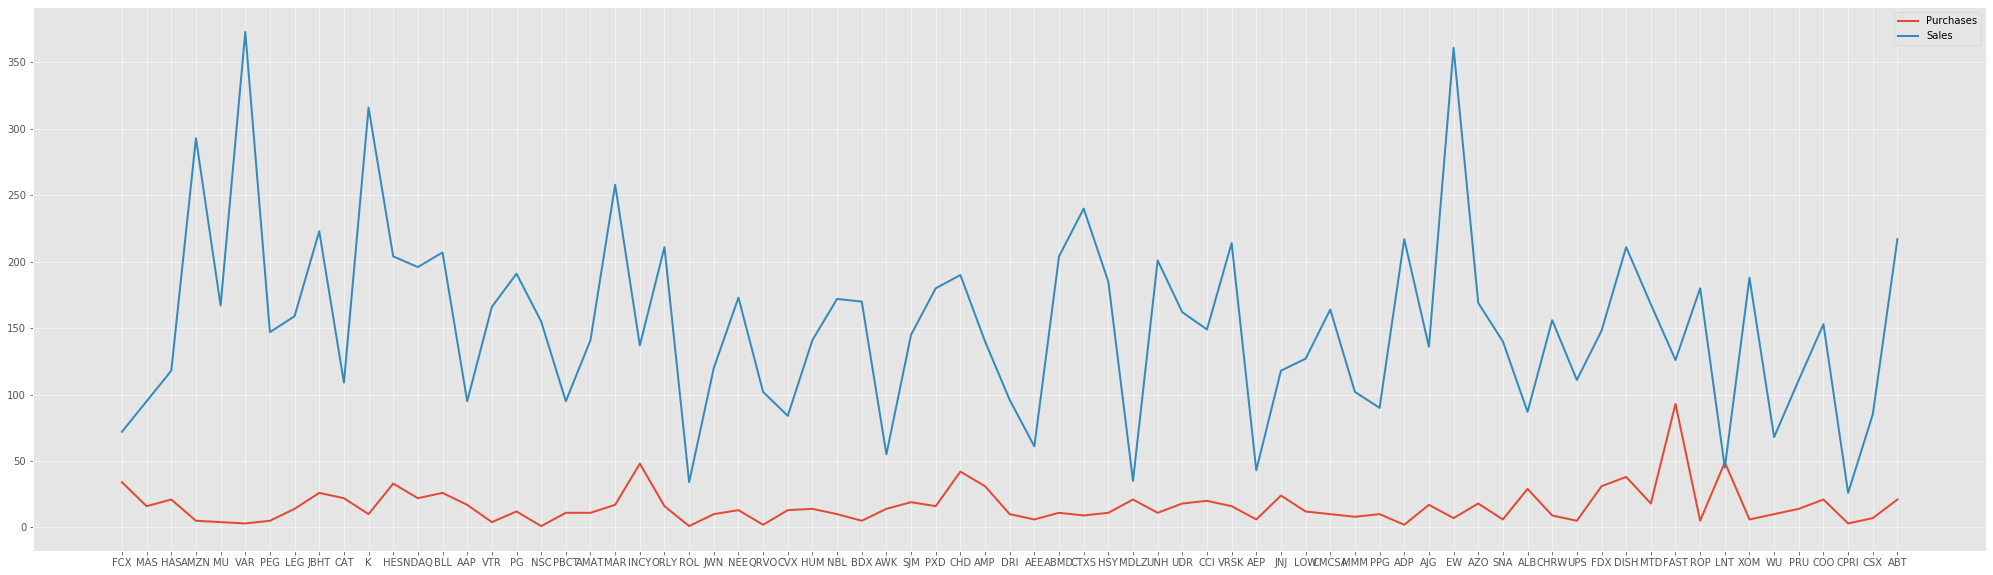

In [448]:
plt.figure(figsize=(35,10))
plt.plot(list(models_dict.keys()), total_buys_list, label = 'Purchases')
plt.plot(total_sales_list,label = 'Sales')
plt.legend()